In [1]:
!pip install segyio

     |████████████████████████████████| 89 kB 1.4 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import segyio
import matplotlib.pyplot as plt
import s3fs
from PIL import Image
%matplotlib inline

## Function to remove outliers and normalize the volume

In [3]:
def clip_normalize_cube(cube, percentile=99.5):
    right = np.percentile(cube, percentile)
    left = np.percentile(cube, 100 - percentile)
    bound = np.max([np.abs(left), np.abs(right)])
    np.clip(cube, -bound, bound, cube)
    cube /= bound
    return cube

In [4]:
def process_volume(volume):
    volume = volume.transpose((0, 2, 1))
    
    #removing outliers
    volume = clip_normalize_cube(volume)
    
    # transforming from [-1.0:1.0] float space to [0:255] uint space
    volume = ((volume + 1) * 255 // 2)
    
    return volume

In [5]:
def extract_inlines(s3_path, local_path, save_dir, volume_name, start_idx):
    # creates S3 File System
    fs = s3fs.S3FileSystem()
    
    # loads the volume locally 
    fs.get(s3_path, local_path)
    
    volume = segyio.tools.cube(local_path)
    
    print(f'Volume reading complete, shape: {volume.shape}')
    
    volume = process_volume(volume)
    
    # saves inlines as PNG images
    idx = start_idx
    for inline in volume:
        plt.imsave(f'{save_dir}/{volume_name}_'+str(idx)+'.png', inline.astype(int) , cmap='gray')
        idx += 1

## Create Folders for Local Volumes and Inlines

In [7]:
!mkdir seg_volumes

In [9]:
!mkdir inlines

## Kerry volume

In [10]:
extract_inlines(f's3://ml-for-seismic-data-interpretation/SEG-Y/Kerry3e.sgy',
                f'seg_volumes/Kerry.sgy',
                'inlines', 
                'kerry', 
                511)

Volume reading complete, shape: (286, 730, 1252)


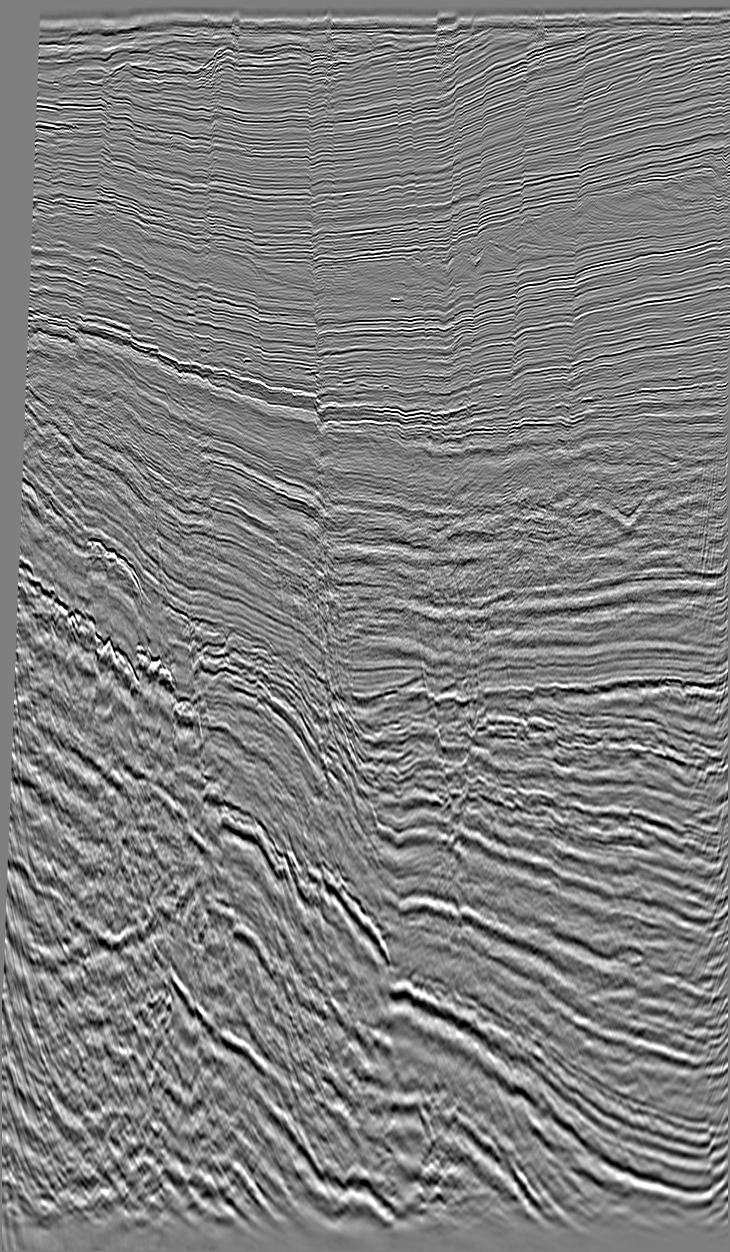

In [11]:
Image.open('inlines/kerry_550.png')

## Parihaka Volume 

In [12]:
extract_inlines(f's3://ml-for-seismic-data-interpretation/SEG-Y/Parihaka_PSTM_full-3D.sgy',
                f'seg_volumes/Parihaka.sgy',
                'inlines', 
                'parihaka', 
                1735)

Volume reading complete, shape: (923, 1126, 1168)


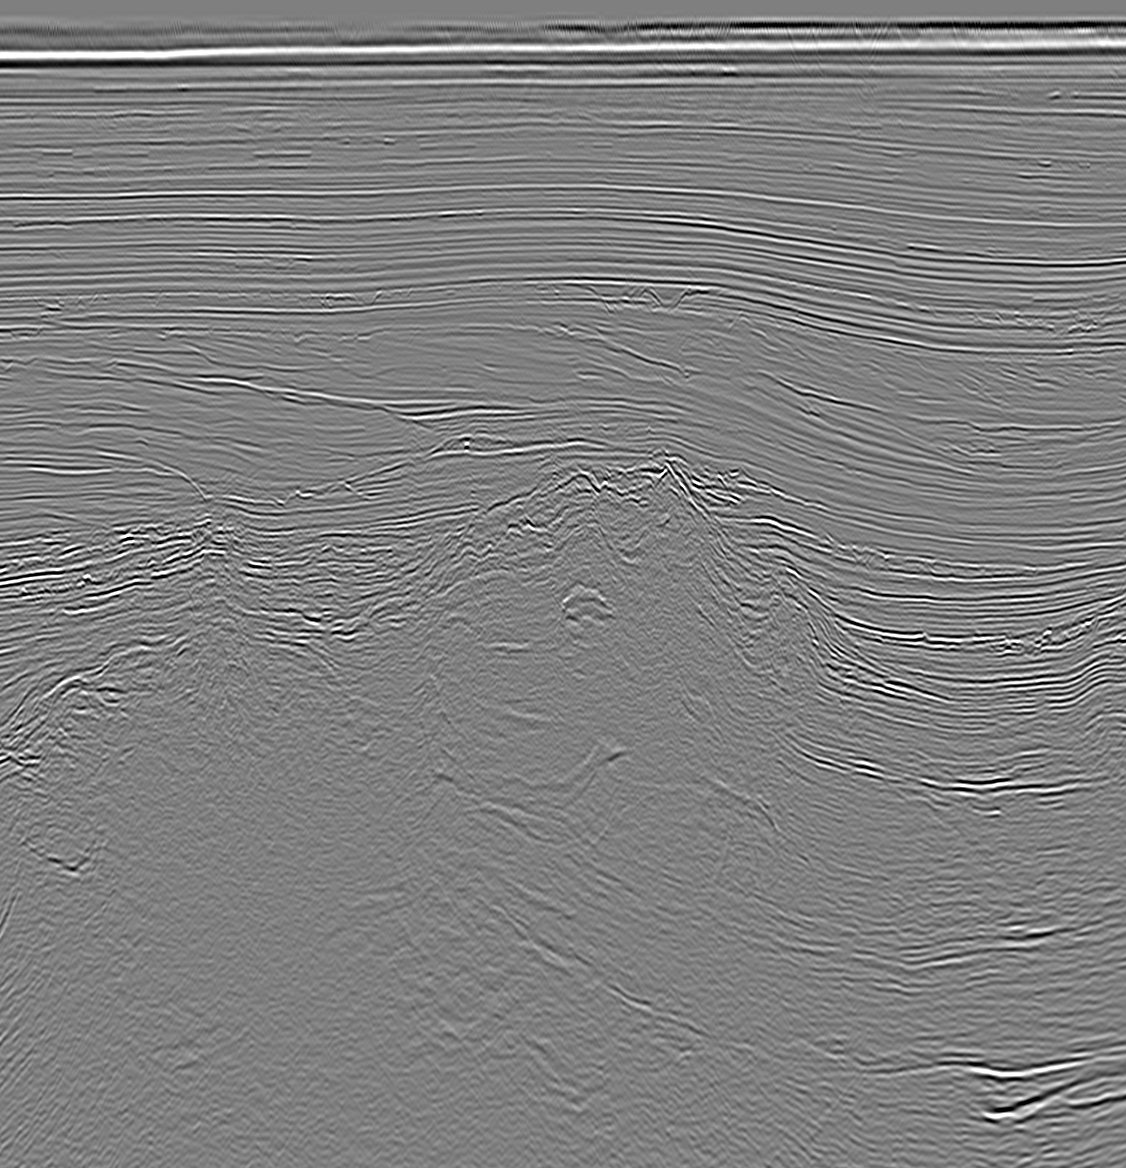

In [13]:
Image.open('inlines/parihaka_1736.png')

## Poseidon Volume 
### Note - Poseidon volume requires large RAM resources for processing. We are using instance with 256Gb of RAM (ml.m4.16xlarge)

In [14]:
extract_inlines(f's3://ml-for-seismic-data-interpretation/SEG-Y/Poseidon_i1000-3600_x900-3200.sgy',
                f'seg_volumes/Poseidon.sgy',
                'inlines', 
                'poseidon', 
                1000)

Volume reading complete, shape: (2601, 2301, 1326)


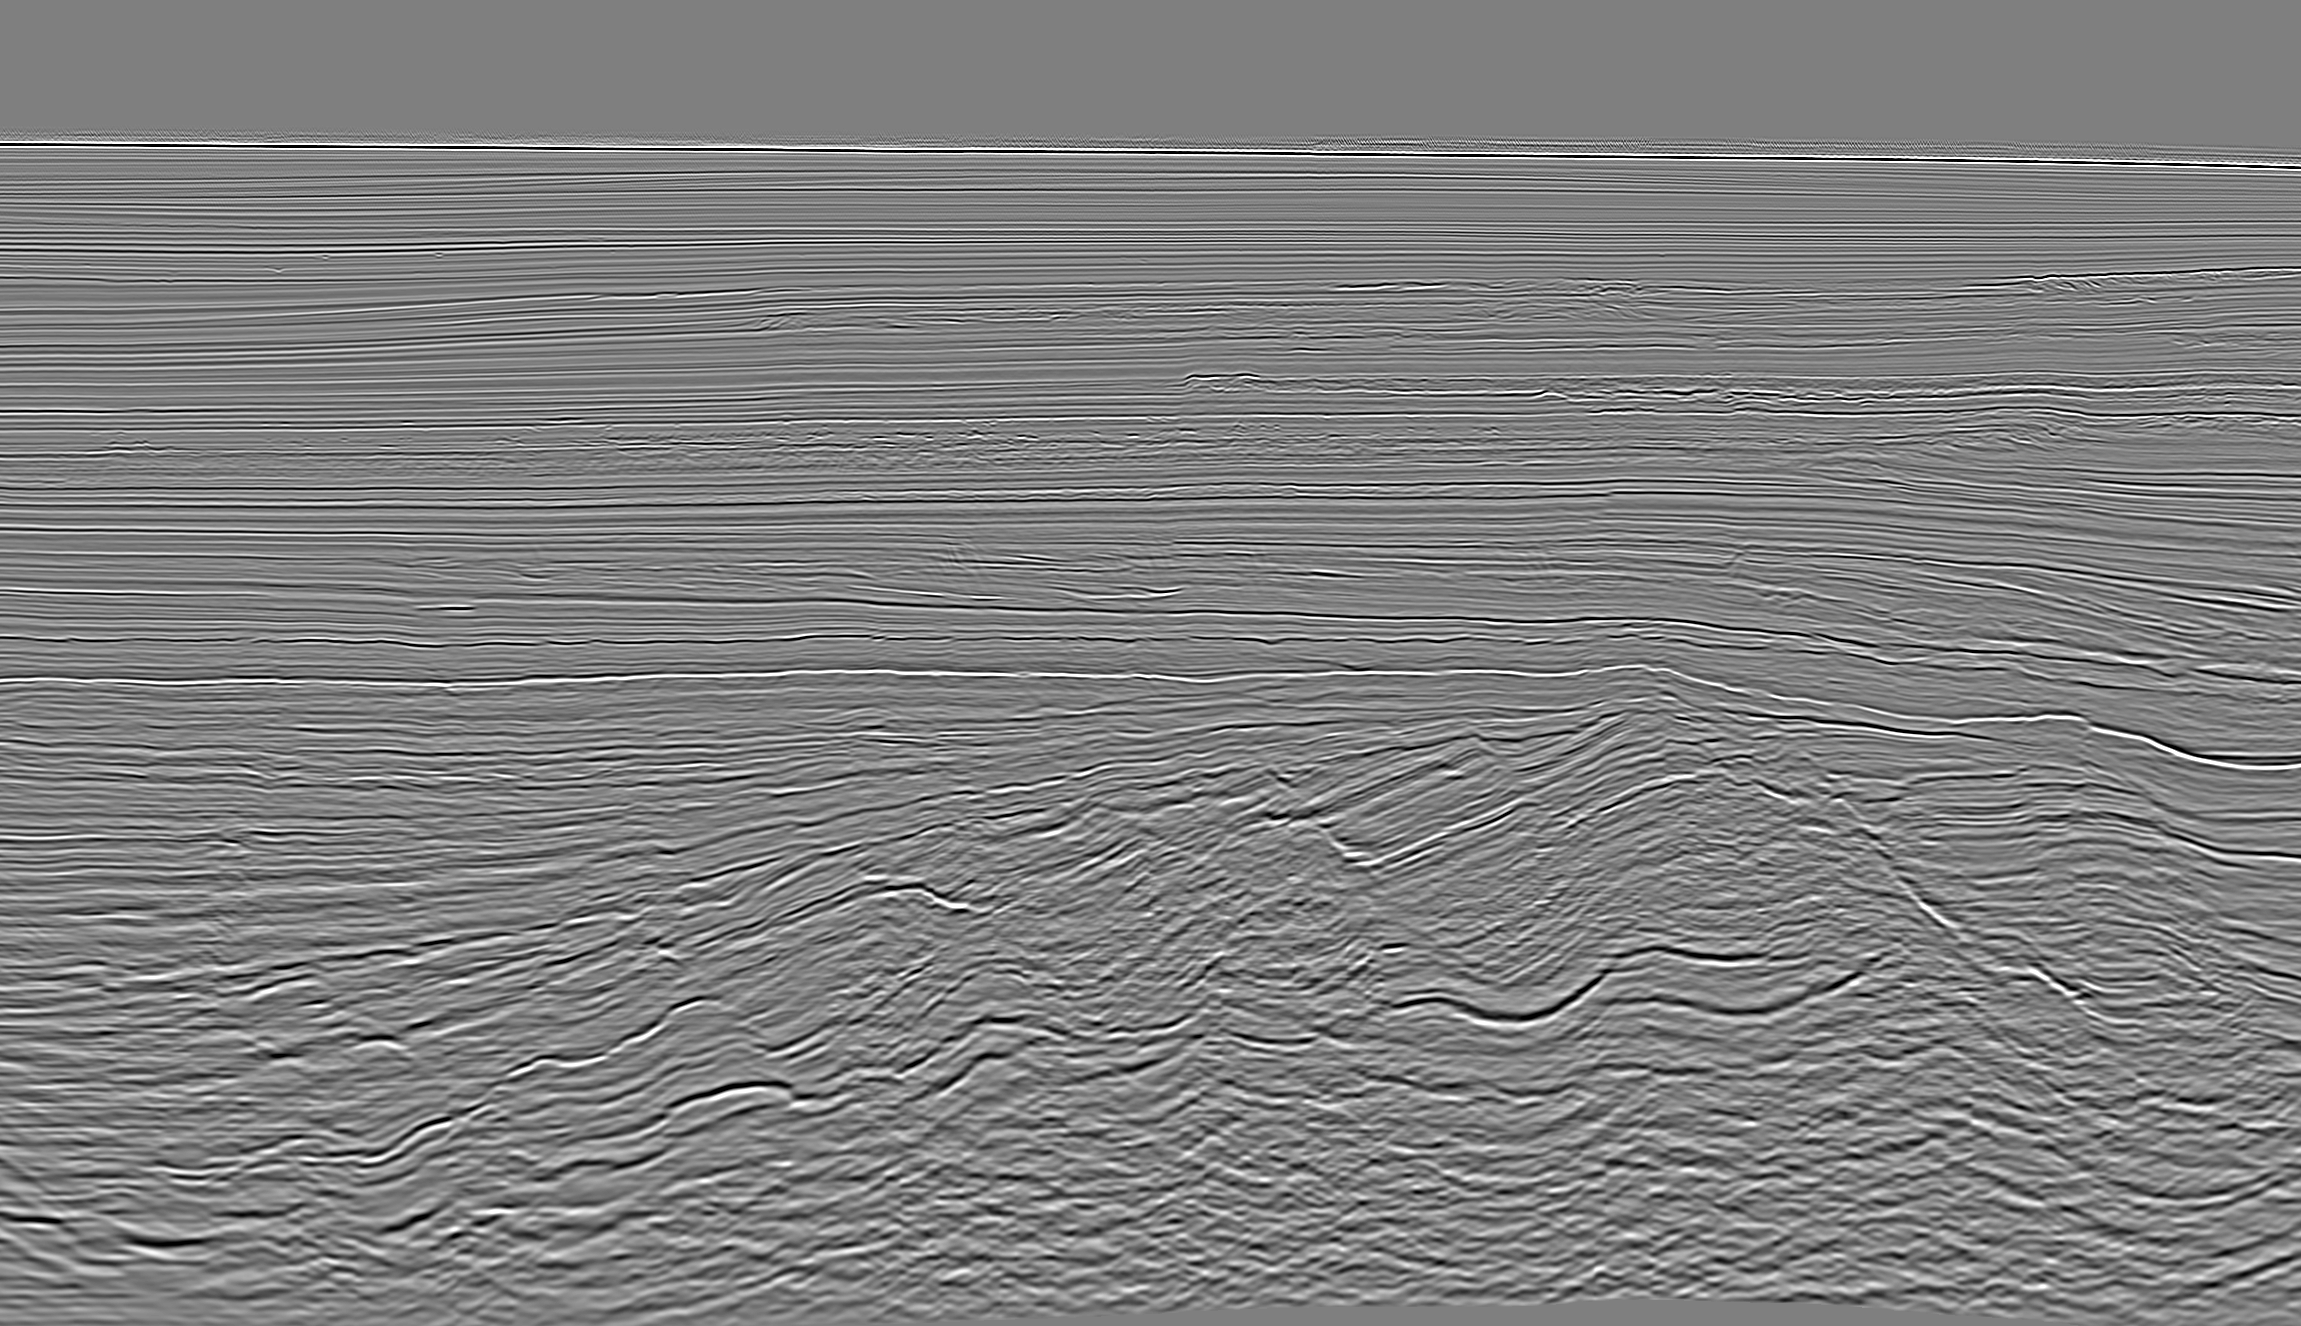

In [15]:
Image.open('inlines/poseidon_1001.png')

## Upload Inlines to S3

In [ ]:
!aws s3 cp --recursive inlines s3://ml-for-seismic-data-interpretation/raw_data/inlines/
    